## Preparation

In [1]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Misc
import warnings
warnings.filterwarnings("ignore")

## Data

In [2]:
# Read in the data
dat = pd.read_csv("Data/restaurant_data.csv")

In [3]:
# View the head of the data
dat.head()

,name,url,phone,address,rating,review_count,neighborhood,price_range,category,region,...,Vermouth Bars,Wine & Spirits,Wraps,Bangladeshi,Bulgarian,Champagne Bars,Iberian,Piadina,Poutineries,Shaved Snow
0,a baked joint,https://www.yelp.com/biz/a-baked-joint-washing...,(202) 408-6985,430 K St NW,4.5,1918,NaN,1.0,"['Coffee & Tea', 'Breakfast & Brunch', 'Sandwi...",Washington DC,...,0,0,0,0,0,0,0,0,0,0
1,zaytinya,https://www.yelp.com/biz/zaytinya-washington,(202) 638-0800,701 9th St NW,4.0,4687,NaN,3.0,"['Greek', 'Turkish', 'Lebanese']",Washington DC,...,0,0,0,0,0,0,0,0,0,0
2,le diplomate,https://www.yelp.com/biz/le-diplomate-washington,(202) 332-3333,1601 14th St NW,4.5,3607,Logan Circle,3.0,"['Brasseries', 'French', 'Breakfast & Brunch']",Washington DC,...,0,0,0,0,0,0,0,0,0,0
3,unconventional diner,https://www.yelp.com/biz/unconventional-diner-...,(202) 847-0122,1207 9th St NW,4.5,1166,Shaw,2.0,"['American (New)', 'Breakfast & Brunch']",Washington DC,...,0,0,0,0,0,0,0,0,0,0
4,old ebbitt grill,https://www.yelp.com/biz/old-ebbitt-grill-wash...,(202) 347-4800,675 15th St NW,4.0,8513,NaN,2.0,"['Bars', 'American (Traditional)', 'Breakfast ...",Washington DC,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Drop unnecessary columns
dat = dat.drop(columns=['name','url','phone','address','neighborhood','category'])

In [5]:
# Convert michelin_star to dummy
dat.michelin_star[dat['michelin_star'] != 0] = 1

In [6]:
# View the data type of each column
dat[['rating', 'review_count', 'price_range', 
     'region', 'michelin_star', 'michelin_guide']].dtypes

rating            float64
review_count        int64
price_range       float64
region             object
michelin_star       int64
michelin_guide      int64
dtype: object

In [7]:
dat['price_range'] = dat['price_range'].astype(int)

In [8]:
# Count NaNs in each column
dat[['rating', 'review_count', 'price_range', 
     'region', 'michelin_star', 'michelin_guide']].isna().sum()

rating            0
review_count      0
price_range       0
region            0
michelin_star     0
michelin_guide    0
dtype: int64

## Up-sample Minority Class

In [9]:
# Count of each class
dat['michelin_star'].value_counts()

0    9208
1     157
Name: michelin_star, dtype: int64

In [10]:
from sklearn.utils import resample

In [11]:
# Separate majority and minority classes
dat_majority = dat[dat.michelin_star==0]
dat_minority = dat[dat.michelin_star==1]

In [12]:
# Upsample minority class
dat_minority_upsampled = resample(dat_minority, 
                                  replace=True,     # sample with replacement
                                  n_samples=9208,   # to match majority class
                                  random_state=123) # reproducible results

In [13]:
# Combine majority class with upsampled minority class
dat_upsampled = pd.concat([dat_majority, dat_minority_upsampled])

In [14]:
# Display new class counts
dat_upsampled.michelin_star.value_counts()

1    9208
0    9208
Name: michelin_star, dtype: int64

## Split

In [15]:
# Split the data
y = dat_upsampled[['michelin_guide']]
X = dat_upsampled.drop(columns=['region','michelin_star','michelin_guide'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=123)

## Explore Training Set

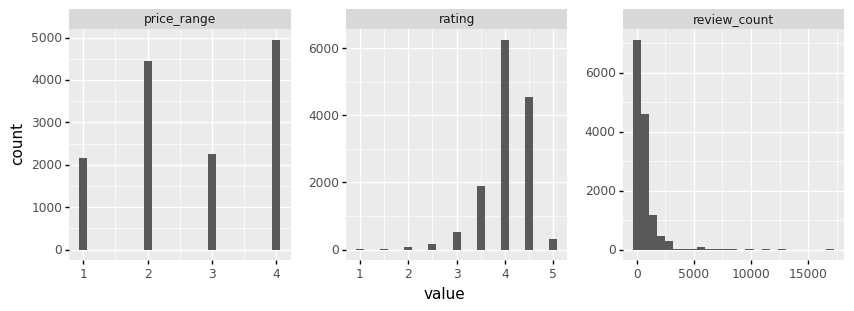

<ggplot: (311093550)>

In [16]:
# Plot the continuous variables
d = train_X[['rating', 'review_count', 'price_range']].melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25,'hspace':0.3})
)

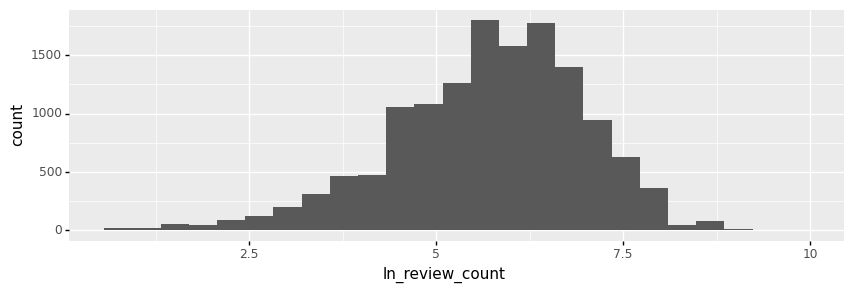

<ggplot: (311225354)>

In [17]:
# Log transform review_count
d = train_X.copy()
d['ln_review_count'] =  np.log(d['review_count'] + 1)
(
    ggplot(d,aes(x="ln_review_count")) +
    geom_histogram(bins=25) +
    theme(figure_size=(10,3))
)

## Pre-processing

In [18]:
# Log transform review_count
dat['review_count'] = np.log(dat['review_count'] + 1)

In [19]:
# Count of each dummy
dummies = dat.columns[6:]
dum_count = dat[dummies].sum().reset_index()
dum_count.columns = ['category','count']
dum_count

,category,count
0,Acai Bowls,15
1,Afghan,9
2,African,13
3,American (New),784
4,American (Traditional),524
...,...,...
181,Champagne Bars,1
182,Iberian,1
183,Piadina,1
184,Poutineries,1


In [20]:
sum(dum_count['count'] < 100)

139

In [21]:
# Droo unnecessary dummies
dum_drop = dum_count.category[dum_count['count'] < 100].to_list()
dat = dat.drop(columns=dum_drop)

## Modeling Pipeline

In [22]:
# (0) Split the data
y = dat_upsampled[['michelin_guide']]
X = dat_upsampled.drop(columns=['region','michelin_star','michelin_guide'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=123)

# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True, random_state=202011)

# (2) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),
                       ('model',None)])

# (3) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # NaiveBayes
    {'model':[NB()]},
    
    # KNN with K tuning param
    {'model':[KNN()],
     'model__n_neighbors':[5,10,25]},
    
    # Decision Tree with the Max Depth Param
    {'model':[DT()],
     'model__max_depth':[1,3,5]},
    
    # Random forest with the N Estimators tuning param
    {'model':[RF()],
     'model__max_depth':[3,5,7,9],
     'model__n_estimators':[500,750,1000],
     'model__max_features':[3,5,7]}
]


# (4) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

# (5) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=202011, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier(n_neighbors=25)],
                          'model__n_neighbors': [5, 10, 25]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [1, 3, 5]},
                         {'model': [RandomForestClassifier()],
                          'model__max_depth': [3, 5, 7, 9],
                          'model__max_features': [3, 5, 7],
                          'model__n_estimators': [500, 750, 1000]}],
             scoring='roc_auc')

In [23]:
search.best_score_

0.9833387432163505

In [24]:
search.best_params_

{'model': KNeighborsClassifier(n_neighbors=25), 'model__n_neighbors': 25}

In [25]:
# Save the best model
knn_mod = search.best_estimator_

In [26]:
# AUC for the training data w/ predict_proba()
m.roc_auc_score(train_y,knn_mod.predict_proba(train_X)[:,1])

0.9946459923895046

In [27]:
# AUC for the test data w/ predict_proba()
m.roc_auc_score(test_y,knn_mod.predict_proba(test_X)[:,1])

0.9860728599516031

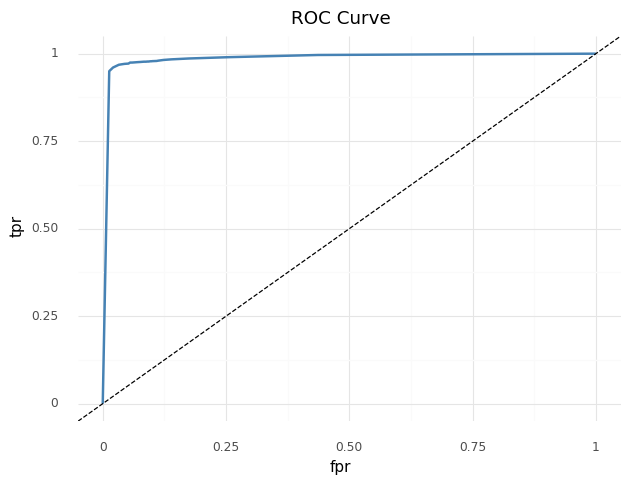

<ggplot: (311247237)>

In [28]:
# Save the predicted probabilities
probs = knn_mod.predict_proba(test_X)
probs = pd.DataFrame(probs,columns=knn_mod.classes_)

# Generate fpr and tpr for different thresholds
fpr, tpr, thresholds = m.roc_curve(test_y, probs[1])

# Plot the ROC curve
( 
    ggplot(pd.DataFrame(dict(fpr=fpr,tpr=tpr)),
           aes(x="fpr",y="tpr")) +
    geom_path(color="steelblue",size=1) +
    geom_abline(intercept=0,slope=1,linetype="dashed") +
    theme_minimal() +
    labs(title="ROC Curve") +
    theme(figure_size=(7,5))
)

## Variable Importance

In [29]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance
from pdpbox import pdp

In [ ]:
# Permute the features to determine importance
vi = permutation_importance(knn_mod,train_X,train_y,n_repeats=5)

In [ ]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

In [ ]:
# Plot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)